# PyRADISE

In [1]:
%reset -f
import numpy as np
import sys, time, copy,os
sys.path.append('../')
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle as pkl


# PySSD
import seaborn as sns
from PySSD.Distribution import Distribution,Gaussian
from PySSD.Detuning import LinearDetuning
# from PySSD.Dispersion import Dispersion
from PySSD.Integrator import Integrator #FixedTrapezoidalIntegrator, SimpsonIntegrator, TrapzIntegrator, DblquadIntegrator


# PyRADISE
import PyRADISE 
from PyRADISE.Detuning import LinearDetuningClass 
from PyRADISE.Noise    import NoiseClass
from PyRADISE.Machine  import MachineClass
from PyRADISE.Grid     import Grid1DClass,Grid2DClass
from PyRADISE.Solver   import SolverClass
from PyRADISE.StabilityDiagram import calc_Stability_Diagram
from PyRADISE.Coefficients import DiffCoeffGrid

# Plotting preparation
from plot_configuration import *
np.set_printoptions(precision=3,suppress=True) 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes,mark_inset
plt.close('all')

Finished configuring the plots.


In [2]:
%matplotlib notebook
pltstorage = '04_Plots_Diffusion/'
pklstorage = '01_Output/'
flag_sidebyside = 1

deletables = ['DiffE', 'DiffN', 'DiffS', 'DiffW', 'DriftE', 'DriftN', 'DriftS', 'DriftW', 'FV_M',
'psi0', 'psis', 'psis1Dx', 'psis1Dy', 'psis2D', 'psisPosX', 'psisPosY',
'dPsis1DdJx', 'dPsis1DdJy', 'dPsis2DdJx', 'dPsis2DdJy']


# def sci_not(num,dec):
#     if num>0:
#         exp = int(np.log10(num)+100)-100
#         sci = (r"$%.10f"%(num/10**exp))[:dec+2+1*(dec>0)]+r"\cdot10^{%d}$"%exp
#     else:
#         sci = '$0$'
#     return sci

def fixCalc(calc):
    if not hasattr(calc,'ntPSI') :
        print("Calc did not have ntPSI")
        calc.ntPSI = calc.nt
        calc.tsPSI = calc.ts

    if not hasattr(calc,'indexPSI') :
        print("Calc did not have indexPSI")
        calc.indexPSI = np.arange(calc.ntPSI)

    if not hasattr(calc,'JMaxSD'):
        print("Calc did not have JmaxSD - set to 18")
        calc.JMaxSD=18
    
    print('L_approx1',calc.Lapprox)
    calc.analyticalLatency(flag_recalculate=1)
    print('L_approx2',calc.Lapprox,calc.Lquadx)
    

# Lebedev scan

In [3]:
################
## Initialize ##

pltstorage = '04_Plots_Diffusion/LebedevPaper/'
pklstorage = '01_Output/LebDiffScan/'
markers = ['*','x','+','1','2','3','4','>','<','o','^','v']


base = 4
logfac = np.logspace(-1,1,7,base=base)
bfac = [-1,-0.7,-0.35,0,0.35,.7,1]
noisefac1= np.array([0,1/5,1/2,1,1,1,1])
noisefac2= np.array([1,1,1,1,1/2,1/5,0])
noisefac3= [1/2,1/2,1/5,1/10,1/20,1/50,0]

# 0,2,4,5,6,7

scanType =7

basename = "lebscan_2D_Nc700r_tmax24h_"
addnames = ["a|a0=%.2e" , "aKconst_a|a0=%.2e" , "g0|g=%.2e" , "g|Kconst_g0|g=%.2e",
            "K|K0=%.2e" , "b|a0=%.2e" , "rel(Kx,Ky)=%.2e" , "Kxconst_rel(Kx,10Ix)=%.2e"]
legends = [r"$a/a_0$", r"$a/a_0$", r"$g_0/g$" ,r"$g_0/g$" ,
           r"$\sigma_{kx}/\sigma_0$", r"$b/a$" , 
#           r"$(\sigma_{kx}-\sigma_{ky})/(\sigma_{kx}+\sigma_{ky})$",
           r"rel$(\sigma_{kx}$-$\sigma_{ky})$",r"rel$(\sigma_{kx}$-$10\sigma_{Ix})$"]
#           r"$(\sigma_{kx}-10\sigma_{Ix})/(\sigma_{kx}+10\sigma_{Ix})$"]
addlegends=["",", $a\sigma_{kx}=$const","",", $g/\sigma_{kx}=$const","","","",""]

scanname = basename + addnames[scanType]
legend = legends[scanType]
xvalss = [logfac,logfac,logfac,logfac,logfac,bfac,(noisefac1-noisefac2)/(noisefac1+noisefac2),(noisefac1-noisefac2)/(noisefac1+noisefac2)]
xvals = xvalss[scanType]
# if scanType in [0,1,2,3,4]:
#     xvals = logfac
# elif scanType in [5]:
#     xvals = bfac
# else:
#     xvals = (noisefac1-noisefac2)/(noisefac1+noisefac2)

    
flag_oneplot = 1

In [69]:
###############
## Load calc ##


calcs = []
# for ifile, filename in enumerate(filenames):
# for ia,a_to_a0 in enumerate(a_to_a0s):
for i in range(7):
    filename = scanname%(xvals[i])
    try:
        with open(pklstorage+filename+'_S2.pkl','rb') as pklfile:
            print('Loading ',pklfile.name)
            calc = pkl.load(pklfile)

        ## Modify result
        if not 'modified'  in dir(calc) :
            calc.SD_calcEffectiveStrength(plane=0,flag_interpStrength=1,mode_R=0,flag_allDQ_R=1,maxmin_ratio=np.nan)
            calc.SD_calcEffectiveStrength(plane=1,flag_interpStrength=1,mode_R=0,flag_allDQ_R=1,maxmin_ratio=np.nan)
            with open(pklstorage+filename+'_S2.pkl','wb') as pklfile:
                print('Dumping ',pklfile.name)
                calc.modified=True
                pkl.dump(calc,pklfile)

        # Delete unnecessary data from this plotting
        for deletable in deletables:
            setattr(calc, deletable, None)
        
#         if i ==0:
#             with open(pklstorage+filename+'_S3.pkl','wb') as pklfile:
#                     print('Dumping ',pklfile.name)
#                     calc.modified=True
#                     pkl.dump(calc,pklfile)
        
        calcs.append(calc)
        print(calc.M.N.sigma_ibsx, calc.M.N.sigma_ibsy,calc.M.Q.ax,calc.M.Q.bx,calc.M.N.sigma_kx)
    except:
        print('Could not find %s'%filename)
        calcs.append(None)

Loading  01_Output/LebDiffScan/lebscan_2D_Nc700r_tmax24h_Kxconst_rel(Kx,10Ix)=-1.00e+00_S2.pkl
0.00025 0.0 5e-05 -3.5e-05 0.0
Loading  01_Output/LebDiffScan/lebscan_2D_Nc700r_tmax24h_Kxconst_rel(Kx,10Ix)=-6.67e-01_S2.pkl
0.00025 0.0 5e-05 -3.5e-05 0.0005
Loading  01_Output/LebDiffScan/lebscan_2D_Nc700r_tmax24h_Kxconst_rel(Kx,10Ix)=-3.33e-01_S2.pkl
0.0001 0.0 5e-05 -3.5e-05 0.0005
Loading  01_Output/LebDiffScan/lebscan_2D_Nc700r_tmax24h_Kxconst_rel(Kx,10Ix)=0.00e+00_S2.pkl
5e-05 0.0 5e-05 -3.5e-05 0.0005
Loading  01_Output/LebDiffScan/lebscan_2D_Nc700r_tmax24h_Kxconst_rel(Kx,10Ix)=3.33e-01_S2.pkl
2.5e-05 0.0 5e-05 -3.5e-05 0.0005
Loading  01_Output/LebDiffScan/lebscan_2D_Nc700r_tmax24h_Kxconst_rel(Kx,10Ix)=6.67e-01_S2.pkl
1e-05 0.0 5e-05 -3.5e-05 0.0005
Loading  01_Output/LebDiffScan/lebscan_2D_Nc700r_tmax24h_Kxconst_rel(Kx,10Ix)=1.00e+00_S2.pkl
0.0 0.0 5e-05 -3.5e-05 0.0005


[ 0.195  0.203 -0.012 -0.044 -0.046 -0.052 -0.054]
[ 0.046  0.044 -0.008 -0.015 -0.015 -0.015 -0.015]
[-1.    -0.667 -0.333  0.     0.333  0.667  1.   ]


<IPython.core.display.Javascript object>


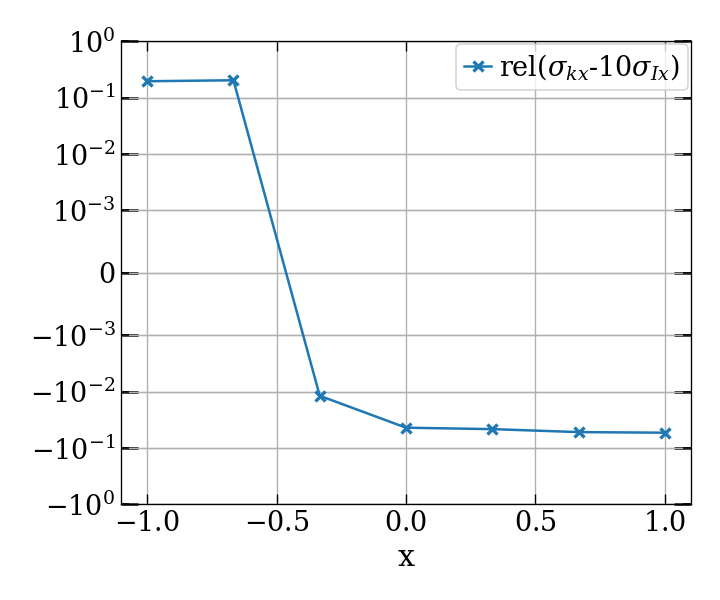

[-1.    -0.667 -0.333  0.     0.333  0.667  1.   ] [ 0.195  0.203 -0.012 -0.044 -0.046 -0.052 -0.054]


<IPython.core.display.Javascript object>


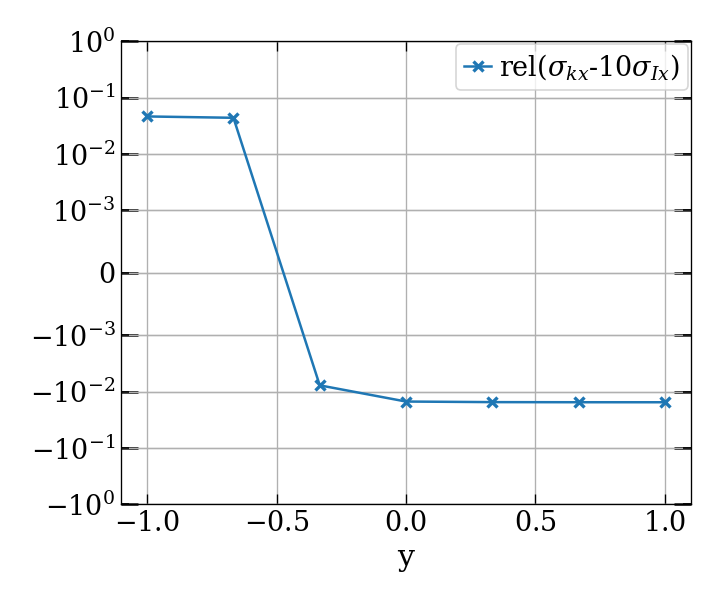

In [70]:
xvals = xvalss[scanType]

growth_rate_x = np.empty(np.size(xvals))
growth_rate_y = np.empty(np.size(xvals))
growth_rate_x[:] = np.nan
growth_rate_y[:] = np.nan

for i , calc in enumerate(calcs):
    try:
        growth_rate_x[i] = np.diff(calc.effectiveStrengthx[:2])/np.diff(calc.tsSD[:2])*calc.time_scale
        growth_rate_y[i] = np.diff(calc.effectiveStrengthy[:2])/np.diff(calc.tsSD[:2])*calc.time_scale
    except:
        print('ERROR',np.diff(calc.effectiveStrengthx[:2]))
        None
print(growth_rate_x)
print(growth_rate_y)
    


if xvals[-1]==base:
    label =r'$\mathrm{log}_{%d}($'%base+legend+r'$)$'+addlegends[scanType]
    x = np.log(xvals)/np.log(base)
else:
    print(xvals)
    label = legend
    x = np.array(xvals)
if 1:
    fig1=plt.figure()
    ind = np.isfinite(growth_rate_x)
    print(x,growth_rate_x)
    plt.plot(x[ind],growth_rate_x[ind],'x-',label=label)
    plt.legend(loc=0)
    plt.xlabel('x')
    ax1 = plt.gca()
    
    fig2=plt.figure()
    ind = np.isfinite(growth_rate_y)
    plt.semilogy(x[ind],growth_rate_y[ind],'x-',label=label)
    plt.legend(loc=0)
    plt.xlabel('y')
    
    ax2 = plt.gca()
    for ax in [ax1,ax2]:
        ax.tick_params(axis='y',length=10,width=1.5)
        ax.tick_params(axis='y',which='minor',length=5,width=1)
        ax.grid(True,which="both")
        ax.set_yscale('symlog', linthreshy=0.001)
        ax.set_ylim(-1,1)
    fig1.tight_layout()
    fig2.tight_layout()
data = {'label':label,'x':x,'growth_rate_x':growth_rate_x,'growth_rate_y':growth_rate_y}
with open(pklstorage+'GR0_%s.pkl'%(scanname%xvals[-1]),'wb') as pklfile:
    pkl.dump(data,pklfile)

<IPython.core.display.Javascript object>


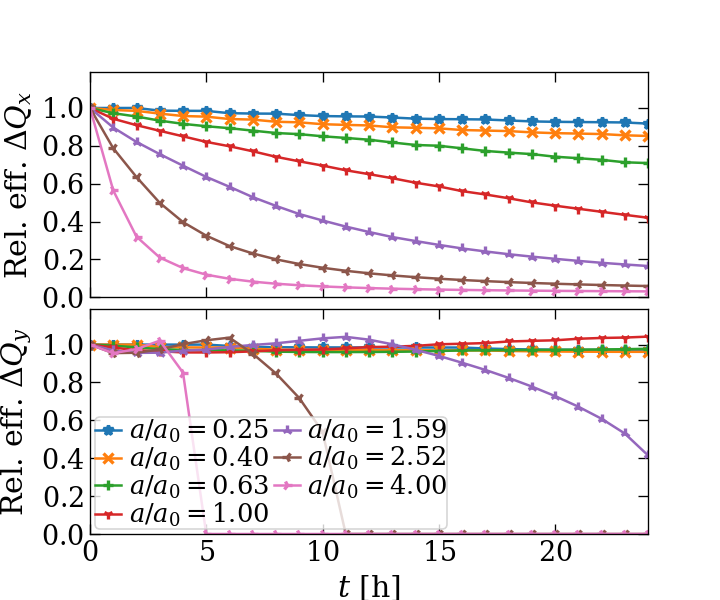

0 [1.    1.    1.    0.986 0.985 0.985 0.973 0.971 0.97  0.962 0.957 0.956
 0.955 0.95  0.944 0.942 0.94  0.939 0.934 0.929 0.927 0.926 0.925 0.923
 0.918]
a=1.25e-05 , b=-8.75e-06 , g=1.00e-02
1 [1.    0.989 0.985 0.97  0.958 0.954 0.942 0.939 0.927 0.924 0.914 0.911
 0.908 0.898 0.895 0.892 0.884 0.881 0.878 0.871 0.867 0.865 0.862 0.856
 0.852]
a=1.98e-05 , b=-1.39e-05 , g=1.00e-02
2 [1.    0.973 0.955 0.933 0.916 0.904 0.893 0.88  0.868 0.862 0.851 0.842
 0.832 0.818 0.805 0.801 0.787 0.773 0.764 0.756 0.743 0.735 0.726 0.713
 0.709]
a=3.15e-05 , b=-2.20e-05 , g=1.00e-02
3 [1.    0.943 0.909 0.879 0.85  0.821 0.798 0.771 0.742 0.718 0.696 0.671
 0.651 0.629 0.605 0.586 0.561 0.543 0.523 0.502 0.484 0.468 0.452 0.436
 0.42 ]
a=5.00e-05 , b=-3.50e-05 , g=1.00e-02
4 [1.    0.897 0.821 0.756 0.695 0.636 0.584 0.529 0.483 0.44  0.406 0.374
 0.345 0.319 0.297 0.277 0.258 0.243 0.228 0.215 0.204 0.193 0.183 0.174
 0.166]
a=7.94e-05 , b=-5.56e-05 , g=1.00e-02
5 [1.    0.787 0.635 0.499 0.3

In [51]:
xvals=xvalss[scanType]

mpl.rcParams.update({'lines.markeredgewidth':2,
                     'lines.markersize':6})
if flag_oneplot:
#     fig1,axs = plt.subplots(2,1,sharex=True,figsize=(figwidth, figheight*1.38))
    fig1,axs = plt.subplots(2,1,sharex=True,figsize=(figwidth, figheight*1.0))
    fig2=fig1
    ax1 =axs[0] ; ax2=axs[1]
else:
    fig1,ax1=plt.subplots(1,figsize=(figwidth*0.7, figheight*1))
    fig2,ax2=plt.subplots(1)


# r'$\mathrm{log}_{10}(a/a_0)$'
for i , calc in enumerate(calcs):
    print(i,calc.effectiveStrengthx)
    xval=xvals[i]
    ylabel=xlabel=legend+'$=$%.2f'%xval+addlegends[scanType]
    if scanType>=6:
        ylabel=xlabel=legend+'=%s'%['-1','-2/3','-1/3','0','1/3','2/3','1'][i]#'$=%.2f$'%xval+addlegends[scanType]
    
    try:
        outx=calc.SD_plotEffectiveStrength(plane=0,label=xlabel,flag_plotInscribed=0,ax=ax1,
                                           iTime_step=1,fmt_string='%s-'%markers[i], minIntensity=0)
        outy=calc.SD_plotEffectiveStrength(plane=1,label=ylabel,flag_plotInscribed=0,ax=ax2,
                                           iTime_step=1,fmt_string='%s-'%markers[i])

        print('a=%.2e , b=%.2e , g=%.2e'%(calc.M.Q.ax,calc.M.Q.bx,calc.M.gx))
    except:
        None
# fig1.tight_layout()
# ax1.legend(loc=1)
add=''#'(J_x,J_y)'
ax1.set_ylabel(r'Rel. eff. $\Delta Q_x%s$'%add)
ax2.set_ylabel(r'Rel. eff. $\Delta Q_y%s$'%add)

ymax = [1.49,1.19][scanType<7]
ax1.set_xlim(0,25)
for ax in [ax1,ax2]:
    ax.set_yticks(0.2*np.arange(8))
    ax.set_ylim(ymax-1.19,ymax)
    ax.set_ylim(0,ymax)
    ax.set_xlim(0,24)
    ax.grid(False)


# if flag_sidebyside:
#     for fig in [fig1,fig2]:
#         fig.set_size_inches(figwidth*0.6, figheight*1)
#         fig.tight_layout()
if flag_oneplot :
    ax1.set_xlabel(None)
    fig1.subplots_adjust(hspace=0.05)
    ax1.get_legend().remove()
    if scanType in [0,1,2,3,4,5,7]:
        ax2.legend(loc=3,ncol=2,columnspacing=0.2,borderaxespad=0.2,borderpad=0,labelspacing=0,fontsize=ticksize*.95)
    else:
        ax2.legend(loc=[(0.01,.91),3][0],ncol=2,columnspacing=0.2,borderaxespad=0.,borderpad=0,labelspacing=-.2,fontsize=ticksize*.95)

    
if flag_oneplot:
    fig1.savefig(pltstorage+'RelDQ_'+scanname%xvals[-1]+'nogrid.pdf')
else:
    fig1.savefig(pltstorage+'RelDQx_'+scanname%xvals[-1]+'.pdf')
    fig2.savefig(pltstorage+'RelDQy_'+scanname%xvals[-1]+'.pdf')

<IPython.core.display.Javascript object>


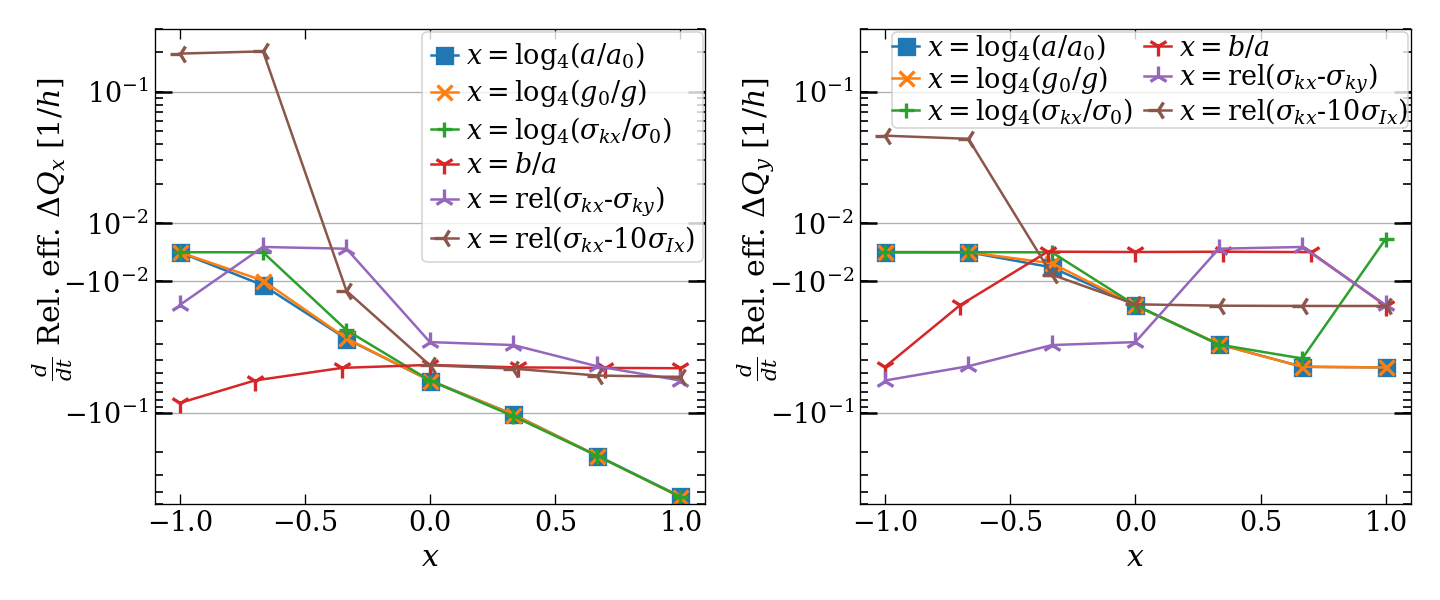

01_Output/LebDiffScan/GR0_lebscan_2D_Nc700r_tmax24h_a|a0=4.00e+00.pkl
{'growth_rate_y': array([ 0.   , -0.   , -0.005, -0.015, -0.03 , -0.045, -0.045]), 'x': array([-1.   , -0.667, -0.333,  0.   ,  0.333,  0.667,  1.   ]), 'label': '$\\mathrm{log}_{4}($$a/a_0$$)$', 'growth_rate_x': array([-0.   , -0.011, -0.027, -0.057, -0.103, -0.213, -0.436])}
01_Output/LebDiffScan/GR0_lebscan_2D_Nc700r_tmax24h_g0|g=4.00e+00.pkl
{'growth_rate_y': array([ 0.   , -0.   , -0.004, -0.015, -0.03 , -0.045, -0.045]), 'x': array([-1.   , -0.667, -0.333,  0.   ,  0.333,  0.667,  1.   ]), 'label': '$\\mathrm{log}_{4}($$g_0/g$$)$', 'growth_rate_x': array([-0.   , -0.01 , -0.027, -0.057, -0.103, -0.213, -0.439])}
01_Output/LebDiffScan/GR0_lebscan_2D_Nc700r_tmax24h_K|K0=4.00e+00.pkl
{'growth_rate_y': array([ 0.   , -0.   , -0.   , -0.015, -0.03 , -0.039,  0.005]), 'x': array([-1.   , -0.667, -0.333,  0.   ,  0.333,  0.667,  1.   ]), 'label': '$\\mathrm{log}_{4}($$\\sigma_{kx}/\\sigma_0$$)$', 'growth_rate_x': arra

/home/sfuruset/miniconda3/lib/python3.5/site-packages/matplotlib/ticker.py:2241: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


In [80]:
# scannames = [
# "GR0_lebscan_2D_Nc700r_tmax24h_g|Kconst_g0|g=4.00e+00",
# "GR0_lebscan_2D_Nc700r_tmax24h_g0|g=4.00e+00",
# "GR0_lebscan_2D_Nc700r_tmax24h_aKconst_a|a0=4.00e+00",
# "GR0_lebscan_2D_Nc700r_tmax24h_a|a0=4.00e+00",
# ]


# fig1,axs = plt.subplots(2,1,sharex=True,figsize=(figwidth, figheight*1.6))
fig1,axs = plt.subplots(1,2,sharex=True,figsize=(figwidth*2, figheight*1))
ax1 =axs[0] ; ax2=axs[1]
cnt=0
for i,addname in enumerate(addnames):
    if i in [1,3]: continue
    xvals = xvalss[i]
    filename = "GR0_"+basename+addname%xvals[-1]
    try:
        with open(pklstorage+filename+'.pkl','rb') as pklfile:
            print(pklfile.name)
            data = pkl.load(pklfile)
        print(data)
        indx = data['growth_rate_x']<10
        indy = data['growth_rate_y']<10
        marker = [markers[cnt],'s'][cnt==0]
        cnt+=1
        ms=[9,12][cnt>3]
        ax1.semilogy(data['x'][indx],data['growth_rate_x'][indx],'%s-'%marker,ms=ms,label='$x=$'+data['label'])
        ax2.semilogy(data['x'][indy],data['growth_rate_y'][indy],'%s-'%marker,ms=ms,label='$x=$'+data['label'])
    except:
        print('%s is not ready'%scanname)

ax1.set_xlabel(None)

# ax1.get_legend().remove()
# ax2.legend(loc=(0,1))


yticks = []
for jj in range(4):
    start =(-1)**(jj%2)*10**(-2+jj//2)
    stop =(-1)**(jj%2)*10**(-1+jj//2)
    yticks=np.concatenate((yticks,np.linspace(start,stop,10)))

for ax in [ax1,ax2]:
    ylim = ax.get_ylim()
    if ylim[1]/ylim[0]<10:
        ax.set_ylim(10**np.floor(np.log10(ylim[0]))*.9,1.1*10**np.ceil(np.log10(ylim[1])))
    ax.tick_params(axis='y',length=10,width=1.5)
    ax.tick_params(axis='y',which='minor',length=5,width=1)
#     ax.grid(True,which="both")
    ax.grid(True,which='major',axis='y')
    
    ax.set_yscale('symlog', linthreshy=0.01,linscaley=.2)
    ax.set_yticks([-1,-0.1,-0.01,0.01,0.1,1])
    ax.set_yticks(yticks,minor=True) ;

ax1.legend(loc=0)
# ax1.get_legend().remove()
ax2.legend(loc=[(0,.9),0][1],ncol=2,columnspacing=0.4,borderaxespad=0.1,borderpad=0,labelspacing=0)

ylabel = r'        $\frac{d}{dt}$ Rel. eff. $\Delta Q_%s$ $[1/h]$'
for ia,ax in enumerate([ax1,ax2]):
    ax.set_ylabel(ylabel%['x','y'][ia],labelpad=-7)
    ax.set_ylim(-.5,.3)
    
ax1.set_xlabel('$x$')
ax2.set_xlabel('$x$')
fig1.tight_layout()
fig1.subplots_adjust(hspace=0.07)    
    
fig1.savefig(pltstorage+'RelDQ_t0_Lebedevscan.pdf')


# NEW pop scans

## Test case

In [21]:
pltstorage = '04_Plots_Diffusion/'
pklstorage2 = "NEW_POP"

pklstorageLoc = pklstorage #+pklstorage2
###############
## Load calc ##
study =2
if study==1:
    filenames = [
        "calc_Dt_ax7.50e-04_bx-ax-0.70_gx0e+00_BC0_2D_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-1.5e-03_imDQx1.3e-04_finda1111_Nc700r_tmax3s_S2.pkl",
         "calc_Dt_ax7.50e-04_bx-ax-0.70_gx0e+00_BC0_2D_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-1.5e-03_imDQx1.3e-04_finda1110_Nc700r_tmax7s_S2.pkl",
    #      "calc_Dt_ax7.50e-04_bx-ax-0.70_gx0e+00_BC0_2D_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx0.0e+00_imDQx5.0e-04_finda1111_Nc700r_tmax100s_S2.pkl",
    #     "calc_Dt_ax1.50e-04_bx-ax-0.70_gx0e+00_BC0_2D_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx0.0e+00_imDQx1.0e-04_finda1101_Nc700r_tmax16m_S2.pkl",
        "calc_D0_ax7.50e-04_bx-ax-0.70_gx0e+00_BC0_2D_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx0.0e+00_imDQx5.0e-04_finda1100_Nc700r_tmax1000slog_S2.pkl",
    #     "calc_D0_ax7.50e-04_bx-ax-0.70_gx0e+00_BC0_2D_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx0.0e+00_imDQx5.0e-04_finda1101_Nc700r_tmax1000slog_S2.pkl",
    ]
    labels = [r'Case 1, $\alpha(t)$',r'Case 1, $\alpha(0)$','Case 2','','']

elif study==2:
    flag_updateReQ = 1
    filenames = [
        "calc_Dt_ax5.09e-05_bx-ax-0.75_gx0e+00_BC0_2D_Kx6.4e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-7.5e-05_imDQx3.5e-06_finda11%d1_Nc700r_tmaxX_S2.pkl"%flag_updateReQ,
#         "calc_Dt_ax5.09e-05_bx-ax-0.75_gx0e+00_BC0_2D_Kx6.4e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-7.5e-05_imDQx3.5e-06_finda11%d1_Nc700r_tmaxX_S2.pkl"%0,
        "calc_Dt_ax3.53e-05_bx-ax-0.98_gx0e+00_BC0_2D_Kx5.7e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-7.9e-05_imDQx3.7e-06_finda11%d1_Nc700r_tmaxX_S2.pkl"%flag_updateReQ,
        "calc_Dt_ax3.33e-05_bx-ax-1.04_gx0e+00_BC0_2D_Kx4.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-7.8e-05_imDQx3.6e-06_finda11%d1_Nc700r_tmaxX_S2.pkl"%flag_updateReQ,
        "calc_Dt_ax2.75e-05_bx-ax-1.13_gx0e+00_BC0_2D_Kx2.2e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-7.7e-05_imDQx3.6e-06_finda11%d1_Nc700r_tmaxX_S2.pkl"%flag_updateReQ,
        "calc_Dt_ax3.02e-05_bx-ax-1.20_gx0e+00_BC0_2D_Kx7.2e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-8.0e-05_imDQx3.7e-06_finda11%d1_Nc700r_tmaxX_S2.pkl"%flag_updateReQ,
        "calc_Dt_ax2.99e-05_bx-ax-1.19_gx0e+00_BC0_2D_Kx5.4e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-7.5e-05_imDQx3.5e-06_finda11%d1_Nc700r_tmaxX_S2.pkl"%flag_updateReQ,
        "calc_Dt_ax3.16e-05_bx-ax-1.13_gx0e+00_BC0_2D_Kx3.7e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-7.8e-05_imDQx3.6e-06_finda11%d1_Nc700r_tmaxX_S2.pkl"%flag_updateReQ,
            ]
    finda = [1001,1111][flag_updateReQ]
    filenames = [
        "NEWscanMD_Dt_ax4.77e-05_bx-ax-0.81_gx0e+00_Kx1.2e-03_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-7.5e-05_imDQx3.6e-06_finda%d_Nc700r_tmax1s_S2.pkl"%finda,
        "NEWscanMD_Dt_ax3.62e-05_bx-ax-0.95_gx0e+00_Kx1.0e-03_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-7.9e-05_imDQx3.8e-06_finda%d_Nc700r_tmax1s_S2.pkl"%finda,
        "NEWscanMD_Dt_ax3.81e-05_bx-ax-0.91_gx0e+00_Kx6.5e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-7.8e-05_imDQx3.8e-06_finda%d_Nc700r_tmax1s_S2.pkl"%finda,
        "NEWscanMD_Dt_ax3.34e-05_bx-ax-0.95_gx0e+00_Kx3.5e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-7.7e-05_imDQx3.7e-06_finda%d_Nc700r_tmax1s_S2.pkl"%finda,
        "NEWscanMD_Dt_ax3.66e-05_bx-ax-1.19_gx0e+00_Kx1.5e-03_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-8.0e-05_imDQx3.8e-06_finda%d_Nc700r_tmax1s_S2.pkl"%finda,
        "NEWscanMD_Dt_ax3.59e-05_bx-ax-1.20_gx0e+00_Kx1.1e-03_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-7.5e-05_imDQx3.6e-06_finda%d_Nc700r_tmax1s_S2.pkl"%finda,
        "NEWscanMD_Dt_ax3.82e-05_bx-ax-1.12_gx0e+00_Kx7.1e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-7.8e-05_imDQx3.7e-06_finda%d_Nc700r_tmax1s_S2.pkl"%finda,
        "NEWscanMD_Dt_ax3.36e-05_bx-ax-1.24_gx0e+00_Kx3.8e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-7.5e-05_imDQx3.6e-06_finda%d_Nc700r_tmax1s_S2.pkl"%finda,
        ]
    filenames = [
        "NEWscanMD2_Dt_ax4.88e-05_bx-ax-0.83_gx0e+00_Kx1.1e-03_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-8.7e-05_imDQx3.6e-06_finda%d_Nc700r_tmax1s_S2.pkl"%finda,
        "NEWscanMD2_Dt_ax3.70e-05_bx-ax-0.98_gx0e+00_Kx9.8e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-9.2e-05_imDQx3.9e-06_finda%d_Nc700r_tmax1s_S2.pkl"%finda,
        "NEWscanMD2_Dt_ax3.89e-05_bx-ax-0.94_gx0e+00_Kx6.4e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-9.1e-05_imDQx3.8e-06_finda%d_Nc700r_tmax1s_S2.pkl"%finda,
        "NEWscanMD2_Dt_ax3.41e-05_bx-ax-0.98_gx0e+00_Kx3.4e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-8.9e-05_imDQx3.8e-06_finda%d_Nc700r_tmax1s_S2.pkl"%finda,
        "NEWscanMD2_Dt_ax3.74e-05_bx-ax-1.23_gx0e+00_Kx1.4e-03_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-9.3e-05_imDQx3.9e-06_finda%d_Nc700r_tmax1s_S2.pkl"%finda,
        "NEWscanMD2_Dt_ax3.67e-05_bx-ax-1.24_gx0e+00_Kx1.1e-03_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-8.7e-05_imDQx3.6e-06_finda%d_Nc700r_tmax1s_S2.pkl"%finda,
        "NEWscanMD2_Dt_ax3.91e-05_bx-ax-1.16_gx0e+00_Kx7.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-9.0e-05_imDQx3.8e-06_finda%d_Nc700r_tmax1s_S2.pkl"%finda,
        "NEWscanMD2_Dt_ax3.44e-05_bx-ax-1.28_gx0e+00_Kx3.7e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-8.7e-05_imDQx3.7e-06_finda%d_Nc700r_tmax1s_S2.pkl"%finda,    
        ]
    
#     filenamesUp= [
#         "NEWscanMD2_Dt_ax5.37e-05_bx-ax-0.83_gx0e+00_Kx1.1e-03_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-8.6e-05_imDQx3.5e-06_finda1111_Nc700r_tmax1s_S2.pkl",
#         "NEWscanMD2_Dt_ax4.07e-05_bx-ax-0.98_gx0e+00_Kx9.8e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-9.1e-05_imDQx3.7e-06_finda1111_Nc700r_tmax1s_S2.pkl",
#         "NEWscanMD2_Dt_ax4.28e-05_bx-ax-0.94_gx0e+00_Kx6.4e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-9.0e-05_imDQx3.7e-06_finda1111_Nc700r_tmax1s_S2.pkl",
#         "NEWscanMD2_Dt_ax3.76e-05_bx-ax-0.98_gx0e+00_Kx3.4e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-8.9e-05_imDQx3.6e-06_finda1111_Nc700r_tmax1s_S2.pkl",
#         "NEWscanMD2_Dt_ax4.11e-05_bx-ax-1.23_gx0e+00_Kx1.4e-03_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-9.2e-05_imDQx3.8e-06_finda1111_Nc700r_tmax1s_S2.pkl",
#         "NEWscanMD2_Dt_ax4.03e-05_bx-ax-1.24_gx0e+00_Kx1.1e-03_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-8.6e-05_imDQx3.5e-06_finda1111_Nc700r_tmax1s_S2.pkl",
#         "NEWscanMD2_Dt_ax4.30e-05_bx-ax-1.16_gx0e+00_Kx7.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-8.9e-05_imDQx3.6e-06_finda1111_Nc700r_tmax1s_S2.pkl",
#         "NEWscanMD2_Dt_ax3.78e-05_bx-ax-1.28_gx0e+00_Kx3.7e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-8.6e-05_imDQx3.5e-06_finda1111_Nc700r_tmax1s_S2.pkl",
#         ]
#     filenamesLo = [
#         "NEWscanMD2_Dt_ax4.39e-05_bx-ax-0.83_gx0e+00_Kx1.1e-03_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-8.7e-05_imDQx3.5e-06_finda1111_Nc700r_tmax1s_S2.pkl",
#         "NEWscanMD2_Dt_ax3.33e-05_bx-ax-0.98_gx0e+00_Kx9.8e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-9.3e-05_imDQx3.7e-06_finda1111_Nc700r_tmax1s_S2.pkl",
#         "NEWscanMD2_Dt_ax3.50e-05_bx-ax-0.94_gx0e+00_Kx6.4e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-9.2e-05_imDQx3.7e-06_finda1111_Nc700r_tmax1s_S2.pkl",
#         "NEWscanMD2_Dt_ax3.07e-05_bx-ax-0.98_gx0e+00_Kx3.4e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-9.0e-05_imDQx3.6e-06_finda1111_Nc700r_tmax1s_S2.pkl",
#         "NEWscanMD2_Dt_ax3.37e-05_bx-ax-1.23_gx0e+00_Kx1.4e-03_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-9.4e-05_imDQx3.8e-06_finda1111_Nc700r_tmax1s_S2.pkl",
#         "NEWscanMD2_Dt_ax3.30e-05_bx-ax-1.24_gx0e+00_Kx1.1e-03_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-8.7e-05_imDQx3.5e-06_finda1111_Nc700r_tmax1s_S2.pkl",
#         "NEWscanMD2_Dt_ax3.52e-05_bx-ax-1.16_gx0e+00_Kx7.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-9.1e-05_imDQx3.7e-06_finda1111_Nc700r_tmax1s_S2.pkl",
#         "NEWscanMD2_Dt_ax3.09e-05_bx-ax-1.28_gx0e+00_Kx3.7e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-8.8e-05_imDQx3.5e-06_finda1111_Nc700r_tmax1s_S2.pkl",
#         ]
    filenamesUp = [
        "NEWscanMD3_Dt_ax6.10e-05_bx-ax-0.83_gx0e+00_Kx1.0e-03_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-8.6e-05_imDQx3.5e-06_finda1001_Nc700r_tmax1s_S2.pkl",
        "NEWscanMD3_Dt_ax4.62e-05_bx-ax-0.98_gx0e+00_Kx8.8e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-9.1e-05_imDQx3.7e-06_finda1111_Nc700r_tmax1s_S2.pkl",
        "NEWscanMD3_Dt_ax4.86e-05_bx-ax-0.94_gx0e+00_Kx5.7e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-9.0e-05_imDQx3.7e-06_finda1111_Nc700r_tmax1s_S2.pkl",
        "NEWscanMD3_Dt_ax4.27e-05_bx-ax-0.98_gx0e+00_Kx3.1e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-8.9e-05_imDQx3.6e-06_finda1111_Nc700r_tmax1s_S2.pkl",
        "NEWscanMD3_Dt_ax4.11e-05_bx-ax-1.23_gx0e+00_Kx1.4e-03_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-9.2e-05_imDQx3.8e-06_finda1111_Nc700r_tmax1s_S2.pkl",
        "NEWscanMD3_Dt_ax4.03e-05_bx-ax-1.24_gx0e+00_Kx1.0e-03_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-8.6e-05_imDQx3.5e-06_finda1111_Nc700r_tmax1s_S2.pkl",
        "NEWscanMD3_Dt_ax4.30e-05_bx-ax-1.16_gx0e+00_Kx6.7e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-8.9e-05_imDQx3.6e-06_finda1111_Nc700r_tmax1s_S2.pkl",
        "NEWscanMD3_Dt_ax3.78e-05_bx-ax-1.28_gx0e+00_Kx3.6e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-8.6e-05_imDQx3.5e-06_finda1111_Nc700r_tmax1s_S2.pkl",
        ]
    filenamesLo = [
        "NEWscanMD3_Dt_ax3.66e-05_bx-ax-0.83_gx0e+00_Kx1.3e-03_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-8.7e-05_imDQx3.5e-06_finda1111_Nc700r_tmax1s_S2.pkl",
        "NEWscanMD3_Dt_ax2.77e-05_bx-ax-0.98_gx0e+00_Kx1.1e-03_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-9.3e-05_imDQx3.7e-06_finda1111_Nc700r_tmax1s_S2.pkl",
        "NEWscanMD3_Dt_ax2.92e-05_bx-ax-0.94_gx0e+00_Kx7.4e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-9.2e-05_imDQx3.7e-06_finda1111_Nc700r_tmax1s_S2.pkl",
        "NEWscanMD3_Dt_ax2.56e-05_bx-ax-0.98_gx0e+00_Kx3.9e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-9.0e-05_imDQx3.6e-06_finda1111_Nc700r_tmax1s_S2.pkl",
        "NEWscanMD3_Dt_ax3.37e-05_bx-ax-1.23_gx0e+00_Kx1.5e-03_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-9.4e-05_imDQx3.8e-06_finda1111_Nc700r_tmax1s_S2.pkl",
        "NEWscanMD3_Dt_ax3.30e-05_bx-ax-1.24_gx0e+00_Kx1.1e-03_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-8.7e-05_imDQx3.5e-06_finda1111_Nc700r_tmax1s_S2.pkl",
        "NEWscanMD3_Dt_ax3.52e-05_bx-ax-1.16_gx0e+00_Kx7.4e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-9.1e-05_imDQx3.7e-06_finda1111_Nc700r_tmax1s_S2.pkl",
        "NEWscanMD3_Dt_ax3.09e-05_bx-ax-1.28_gx0e+00_Kx3.9e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-8.8e-05_imDQx3.5e-06_finda1111_Nc700r_tmax1s_S2.pkl",
        ]
    filenames = filenames + filenamesLo + filenamesUp
    print(filenames)
    labels = [450,750,1050,1350,1950,2250,2550]
calcs = []


for i,filename in enumerate(filenames):
    try:
        with open(pklstorage+filename,'rb') as pklfile:
            print('Loading ',pklfile.name)
            calc = pkl.load(pklfile)
        print('Loaded')

    except:
        print('Could not find %s'%filename)
        calcs.append(None)
        continue

    fixCalc(calc)
    
    
    # Delete unnecessary data from this plotting
    for deletable in deletables:
        setattr(calc, deletable, None)

    if study==1 or 1:
        calcs.append(calc)
    
    

['NEWscanMD2_Dt_ax4.88e-05_bx-ax-0.83_gx0e+00_Kx1.1e-03_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-8.7e-05_imDQx3.6e-06_finda1111_Nc700r_tmax1s_S2.pkl', 'NEWscanMD2_Dt_ax3.70e-05_bx-ax-0.98_gx0e+00_Kx9.8e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-9.2e-05_imDQx3.9e-06_finda1111_Nc700r_tmax1s_S2.pkl', 'NEWscanMD2_Dt_ax3.89e-05_bx-ax-0.94_gx0e+00_Kx6.4e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-9.1e-05_imDQx3.8e-06_finda1111_Nc700r_tmax1s_S2.pkl', 'NEWscanMD2_Dt_ax3.41e-05_bx-ax-0.98_gx0e+00_Kx3.4e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-8.9e-05_imDQx3.8e-06_finda1111_Nc700r_tmax1s_S2.pkl', 'NEWscanMD2_Dt_ax3.74e-05_bx-ax-1.23_gx0e+00_Kx1.4e-03_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-9.3e-05_imDQx3.9e-06_finda1111_Nc700r_tmax1s_S2.pkl', 'NEWscanMD2_Dt_ax3.67e-05_bx-ax-1.24_gx0e+00_Kx1.1e-03_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-8.7e-05_imDQx3.6e-06_finda1111_Nc700r_tmax1s_S2.pkl', 'NEWscanMD2_Dt_ax3.91e-05_bx-ax-1.16_gx0e+00_Kx7.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-9.0e-05_imDQx3.8e-06_finda1111_Nc700r_tmax1s_

<IPython.core.display.Javascript object>


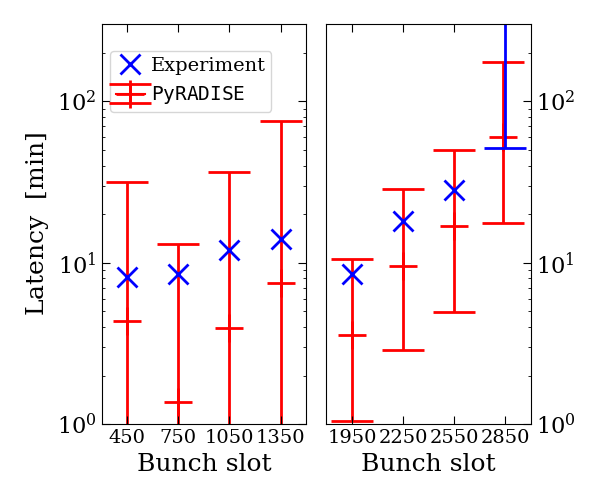

450 lapprox = 6.019e+02   , latency[s] = 2.602e+02 , latency[min] = 4.336, Theory/PyRADISE=2.314
Upp lapprox = 6.019e+02   , latency[s] = 2.602e+02 , latency[min] = 4.336, Theory/PyRADISE=2.314
Low lapprox = 3.825e+01   , latency[s] = 1.538e+01 , latency[min] = 0.256, Theory/PyRADISE=2.487
4.336058305220375 0.22059226125619616 31.638583614362233
750 lapprox = 2.277e+02   , latency[s] = 8.242e+01 , latency[min] = 1.374, Theory/PyRADISE=2.763
Upp lapprox = 1.644e+03   , latency[s] = 6.664e+02 , latency[min] = 11.107, Theory/PyRADISE=2.467
Low lapprox = 6.078e+00   , latency[s] = 2.593e+00 , latency[min] = 0.043, Theory/PyRADISE=2.344
1.373725975495884 0.03719726950114125 13.063036616107762
1050 lapprox = 6.383e+02   , latency[s] = 2.364e+02 , latency[min] = 3.939, Theory/PyRADISE=2.700
Upp lapprox = 4.336e+03   , latency[s] = 1.872e+03 , latency[min] = 31.201, Theory/PyRADISE=2.316
Low lapprox = 1.980e+01   , latency[s] = 8.391e+00 , latency[min] = 0.140, Theory/PyRADISE=2.359
3.93938691

In [22]:
# print latencies
flag_onePlot = 0

if flag_onePlot:
    fig=plt.figure(figsize = (figwidth,figheight*0.85))
    ax1=ax2=fig.gca()
else:
    fig,axes = plt.subplots(1,2)
    ax1,ax2 = axes
MDlatency = [5.6577 +2.529, 6.0327+2.529*1, 9.4317+2.529, 11.5837+2.529,8.4691, 18.1601, 28.1031, 58.5041]
labels = [450,750,1050,1350,1950,2250,2550,2850]
for i,calc in enumerate(calcs[:8]):
    errlabel = label= labelTheory=''
    ls='-'
    axi = [ax1,ax2][i>3]
    if i in [1,5]:
        errlabel=r'$\mathtt{PyRADISE}$'
        label='Experiment'
        labelTheory = 'Theory'
        if 1:
            ls='--'
            
    tunit = 1
    tscale = [1,60][tunit]
    tlabel = ['s','min'][tunit]
    try:
        latTheory = calc.Lapprox/tscale
        latTheory = calc.Lquadx/tscale
#         axi.plot(i,latTheory,'g'+['3','*'][i<0],ms=20,label=labelTheory,zorder=3)
        
        lat = calc.latencyx/tscale 
        print(labels[i],'lapprox = %.3e   , latency[s] = %.3e , latency[min] = %.3f, Theory/PyRADISE=%.3f'%(
                calc.Lapprox,calc.latencyx,calc.latencyx/60,calc.Lapprox/calc.latencyx))

        errorbartype = 3
        if errorbartype ==1:
            etasig0 = 3.85*3.7124e-02 
            etasigmax=4.15*4.2979e-02
            etasigmin=3.55*3.5373e-02

            upper = lat*(etasig0/etasigmin)**2
            lower = lat*(etasig0/etasigmax)**2
        
        elif errorbartype ==2:
            lat *= (3.85/2.4)**2
            upper = lat*(2.4/2.0)**2
            lower = lat*(2.4/2.8)**2
            
        elif errorbartype ==3:
            if i>0:
                calc = calcs[16+i]
                upper = calc.latencyx/tscale
            else: 
                upper = lat*calcs[16+2].latencyx/calcs[2].latencyx
                upper = 26.9*60/tscale 
#                 print('Lapprox',calc[16+i].Lapprox)
            print('Upp lapprox = %.3e   , latency[s] = %.3e , latency[min] = %.3f, Theory/PyRADISE=%.3f'%(
                    calc.Lapprox,calc.latencyx,calc.latencyx/60,calc.Lapprox/calc.latencyx))
            
            calc = calcs[8+i]
            lower = calc.latencyx/tscale
            print('Low lapprox = %.3e   , latency[s] = %.3e , latency[min] = %.3f, Theory/PyRADISE=%.3f'%(
                    calc.Lapprox,calc.latencyx,calc.latencyx/60,calc.Lapprox/calc.latencyx))
            
            simfactor = 3.85   ; noiseind = 0
            lat   *= (simfactor/[3.85,2.4][noiseind])**2  #
            lower *= (simfactor/[4.15,2.8][noiseind])**2  #
            upper *= (simfactor/[3.55,2.0][noiseind])**2  #
            
        print(lat,lower,upper)
        
#         lat,lower,upper = np.array([lat,lower,upper])*1
        
        eb=axi.errorbar(i-0.05*(i==7),lat,yerr = [[lat-lower],[upper-lat]],marker='+',markersize=20,elinewidth=2,color='r',capsize=15,label=errlabel,zorder=1)
#         if i==0 and 1:
#             eb[-1][0].set_linestyle(':')
    except:
        pass
    axi.plot(i,MDlatency[i]*60/tscale,'b'+['x',''][i==7],ms=15,label=label,zorder=2)
    if i==7:
        axi.errorbar(i,MDlatency[i]*60/tscale,yerr = np.array([[MDlatency[i]-51.667],[1000]])*60/tscale,
                     fmt='none',markersize=20,elinewidth=2,color='b',capsize=15,zorder=2)

for i,axi in enumerate([ax1,ax2]):
    axi.set_xticks(np.arange(8))
    axi.set_xticklabels(labels)
    axi.set_xlabel('Bunch slot')
    axi.set_ylim(bottom=0,top=min(axi.get_ylim()[1],155)*60/tscale)
    axi.set_ylim(bottom=[10,0.03][tunit],top=[1e4,300][tunit])
    axi.set_ylim(bottom=[10,1][tunit],top=[1e4,300][tunit])
    axi.set_yscale('log')
    axi.tick_params(axis='x', which='both', labelsize=14)

    
if flag_onePlot:
    plt.axvline(3.5,ls='--',color='k')
    plt.xlim(-0.5,7.5)

else:
    ax1.set_xlim(-0.5,3.5)
    ax2.set_xlim(3.5,7.5)


# plt.ylim(bottom=0,top=60)
# plt.yscale('log')
ax1.legend(loc=(0.04,0.78),frameon=True,handlelength=1.5,labelspacing=.5,fontsize=14)
# ax2.legend(loc=(0.1,0.04),frameon=True,handlelength=1.5,labelspacing=.5,fontsize=14)

ax1.set_ylabel(r'Latency  $[\mathrm{%s}]$'%tlabel)
ax2.yaxis.tick_right()
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
plt.savefig(pltstorage+'/NEW_POP_MD3288_individualBunches_finda%d_tunit%s.eps'%(finda,tlabel))

<IPython.core.display.Javascript object>


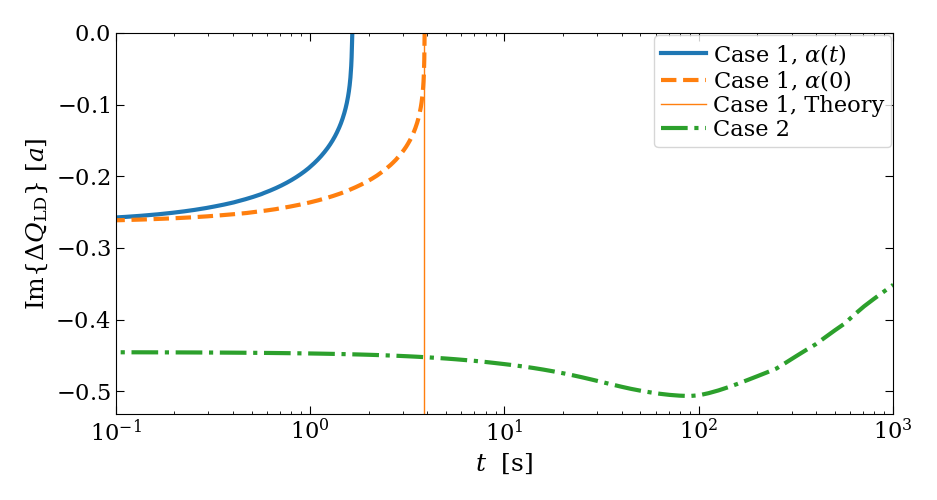

3.84104496793041 1.648931719601841
3.84104496793041 3.882532945989694
[]


In [4]:
# Print growthrate of testcases
figheightpres=5
if i_layout==0:
    plt.figure(figsize=(figwidth,figheightpres*.7))
else:
    plt.figure(figsize=(figwidthM,figheight))

lss=['-','--','-.',':','-']
for i,calc in enumerate(calcs):
    
#     l = plt.plot(calc.tsODE,calc.growthRatex[:calc.ntODE],'--%s'%markers[1+i],label=labels[i])
    if i==2:
        ind = np.where(np.diff(calc.growthRatex)/calc.growthRatex[:-1]<-0.05)[0]
        print(ind)
#         ind = [88 ,90]
        calc.growthRatex[ind]=np.nan
        calc.tsODE[ind] = np.nan
        
    if i in [0,1,2]: l = plt.plot(calc.tsODE,calc.growthRatex[:calc.ntODE]/calc.M.Q.ax,lw=3,ls=lss[i],label=labels[i])
    if i in [3,4]:  l = plt.plot(calc.tsODE[:-1],calc.growthRatex[:calc.ntODE-1]/calc.M.Q.ax,lw=3,ls=lss[i],label=labels[i])
    if i==1: plt.axvline(calc.Lquadx,lw=1,color=l[0].get_color(),label='Case 1, Theory')
        
    try:
        print(calc.Lquadx,calc.latencyx)
    except:
        pass
#     print(calc.growthRatex*1e6)
#     print(labels)
    
# plt.grid(True)
plt.ylim(top=0)
plt.ylabel(r"$\operatorname{Im}\{ \Delta Q_\mathrm{LD}\}$ $[a]$")
plt.xlabel(r'$t$  $[\mathrm{s}]$')
plt.legend(loc=(0.45,0.6),labelspacing=0.07,handlelength=2)
plt.legend(loc=0,labelspacing=0.07,handlelength=2)
plt.xscale('log')
plt.xlim(0.1,1000)
# plt.grid(True,axis='x',which='minor')
plt.tight_layout()
plt.savefig(pltstorage+'NEW_GrowthRateOfTime.eps')

## Octupole scan

In [5]:
# Octupole scan loading
axlist = np.arange(5.5e-4,1.26e-3,5e-5)
Nax = np.size(axlist)
axs = np.zeros((2,2,2,Nax))*np.nan
Mcohs = np.zeros((2,2,2,Nax))*np.nan
LatTheory1= np.zeros((2,2,2,Nax))*np.nan
LatTheory2= np.zeros((2,2,2,Nax))*np.nan
LatPyRADISE = np.zeros((2,2,2,Nax))*np.nan
LatTMAX = np.zeros((2,2,2,Nax))*np.nan
filename_mal = "NEWscan_Dt_ax%.2e_bx-ax-0.70_gx0e+00_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-1.5e-03_imDQx1.3e-04_finda1%d%d%d_Nc700r_tmax1s_S2.pkl"
for flag_compalpha in [0,1]:
    i=flag_compalpha
    for flag_req in [0,1]:
        j=flag_req
        for flag_alpha in [0,1]:
            k=flag_alpha
            
            if i*100+j*10+k in [100,101]:
                continue
            
            
            
            for l,ax in enumerate(axlist):
#                 if l<13:
#                     continue
                    
                filename = filename_mal%(ax,flag_compalpha,flag_req,flag_alpha)
                try:
                    with open(pklstorage+filename,'rb') as pklfile:
                        print('Loading ',pklfile.name)
                        calc = pkl.load(pklfile)
                    print('Loaded')

                except:
                    print('Could not find %s'%filename)
    #                 calcs.append(None)
                    continue

                # Delete unnecessary data from this plotting
    #             for deletable in deletables:
    #                 setattr(calc, deletable, None)

                fixCalc(calc)
                Mcohs[i,j,k,l] = -calc.M.wmodeLdDQx[0].imag/calc.M.taylorAlphax[0].real
                axs[i,j,k,l]=calc.M.Q.ax
                LatTheory1[i,j,k,l] = calc.Lapprox
                LatTheory2[i,j,k,l] = calc.Lquadx
                LatTMAX[i,j,k,l]   = calc.tmax
                print(calc.tmax,LatTMAX[i,j,k,l])
                try:
                    LatPyRADISE[i,j,k,l] = calc.latencyx
                except:
                    LatPyRADISE[i,j,k,l] = np.nan

Could not find NEWscan_Dt_ax5.50e-04_bx-ax-0.70_gx0e+00_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-1.5e-03_imDQx1.3e-04_finda1000_Nc700r_tmax1s_S2.pkl
Could not find NEWscan_Dt_ax6.00e-04_bx-ax-0.70_gx0e+00_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-1.5e-03_imDQx1.3e-04_finda1000_Nc700r_tmax1s_S2.pkl
Could not find NEWscan_Dt_ax6.50e-04_bx-ax-0.70_gx0e+00_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-1.5e-03_imDQx1.3e-04_finda1000_Nc700r_tmax1s_S2.pkl
Could not find NEWscan_Dt_ax7.00e-04_bx-ax-0.70_gx0e+00_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-1.5e-03_imDQx1.3e-04_finda1000_Nc700r_tmax1s_S2.pkl
Could not find NEWscan_Dt_ax7.50e-04_bx-ax-0.70_gx0e+00_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-1.5e-03_imDQx1.3e-04_finda1000_Nc700r_tmax1s_S2.pkl
Could not find NEWscan_Dt_ax8.00e-04_bx-ax-0.70_gx0e+00_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-1.5e-03_imDQx1.3e-04_finda1000_Nc700r_tmax1s_S2.pkl
Could not find NEWscan_Dt_ax8.50e-04_bx-ax-0.70_gx0e+00_Kx1.0e-04_Ky0.0e+00_ibs0e+

In [6]:
calc.tmax

366.328113395419

<IPython.core.display.Javascript object>


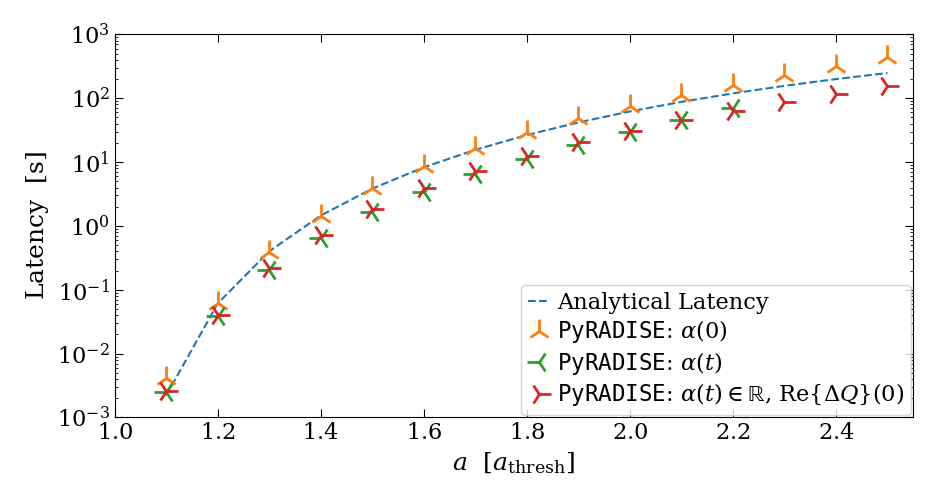

1110 $\mathtt{PyRADISE}$: $\alpha(0)$
[-0.246  0.     0.036  0.02   0.182  0.099  0.023 -0.106 -0.114 -0.181
 -0.223 -0.295 -0.355 -0.38  -0.446]
[  0.004   0.061   0.387   1.427   3.876   8.635  16.815  29.679  48.797
  75.845 113.101 163.536 231.302 322.203 448.694]
[  0.003   0.061   0.401   1.456   4.581   9.494  17.195  26.542  43.221
  62.145  87.827 115.281 149.217 199.679 248.548]
[   0.019    0.218    1.304    4.625   12.331   26.2     49.048   83.083
  131.578  197.151  283.732  396.738  546.554  730.512 1017.549]
1111 $\mathtt{PyRADISE}$: $\alpha(t)$
[-0.101  0.591  0.983  1.213  1.343  1.399  1.397  1.35   1.256  1.122
  0.936  0.682    nan    nan    nan]
[ 0.002  0.039  0.202  0.658  1.64   3.457  6.509 11.295 18.544 29.284
 45.373 70.875    nan    nan    nan]
[  0.002   0.061   0.401   1.456   3.841   8.293  15.601  26.542  41.828
  62.145  87.827 119.237 156.524 199.679 248.548]
[  0.008   0.125   0.638   1.979   4.899  10.241  19.088  31.907  50.312
  74.88  107.183 148

In [20]:
# Octupole scan plotting
LatTheory = LatTheory2

plt.figure(figsize=(figwidthM,figheight))
a_thresh=5e-4

flag_xlog = False

count=0
plt.plot(axs[1,1,1]/a_thresh-1*flag_xlog,LatTheory[1,1,1],'--',label='Analytical Latency')

xxx=axs[1,1,1]/a_thresh-1*flag_xlog
# plt.plot(xxx,xxx**4*10)
# plt.plot(xxx,xxx**4.5*100,'k--',label=r'$\propto(a-a_\mathrm{thresh})^{4.5}$',zorder=-1000)

for flag_compalpha in [1,0]:
    i=flag_compalpha
    for flag_req in [0,1]:
        j=flag_req
#         if j==0: continue
        for flag_alpha in [0,1]:
            k=flag_alpha
            if i*100+j*10+k in [100,101]:
                continue
                
            
            if np.any(np.isfinite(axs[i,j,k])):
                
                count+=1
                
                label = r'$\mathtt{PyRADISE}$: $\alpha(%s)$'%['0','t'][k] 
                if i==0: label+=r'$\in\mathrm{\mathbb{R}}$'
                if j==0: label+=r', $\operatorname{Re}\{\Delta Q\}(%s)$'%(['0','t'][j])

                plt.plot(axs[i,j,k]/a_thresh-1*flag_xlog,LatPyRADISE[i,j,k],ls='',marker=markers[3+count],ms=17,label=label)
                
                print('1%d%d%d'%(i,j,k),label)
                print((LatTheory[i,j,k]-LatPyRADISE[i,j,k])/LatPyRADISE[i,j,k])
                print(LatPyRADISE[i,j,k])
                print(LatTheory[i,j,k])
                print(LatTMAX[i,j,k])

                
yscale='log'
if flag_xlog: 
    plt.xscale('log')
    ax=plt.gca()
    xticks= [.1,.2,.4,1]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks)
plt.yscale(yscale)
# plt.yscale('symlog',linthreshy=10)
plt.legend(loc=4)
plt.xlim(1-.91*flag_xlog,2.55-1*flag_xlog)
plt.ylim(1e-3,1e3)
plt.xlabel(r'$a%s$  $[a_\mathrm{thresh}]$'%(['','-a_\mathrm{thresh}'][flag_xlog]))
plt.ylabel(r'Latency  $[\mathrm{s}]$')
plt.tight_layout()
plt.savefig(pltstorage+'/NEW_POP_octuscan_%s.eps'%yscale)



if 0:
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    ax2.plot(axs[1,1,1]/a_thresh-1*flag_xlog,Mcohs[1,1,1]/(axs[1,1,1]-a_thresh),'m')
    ax2.set_ylabel(r'$\dfrac{\mathrm{Im}\{\Delta Q_{\mathrm{SD}r}-\Delta Q_\mathrm{coh}\}}{a-a_\mathrm{thresh}}$',color='m')
    ax2.set_ylim(0,1)
    plt.tight_layout()
    plt.savefig(pltstorage+'/NEW_POP_octuscan_%s_.eps'%yscale)

# ABP forum scan

In [42]:
deletables = ['DiffE', 'DiffN', 'DiffS', 'DiffW', 'DriftE', 'DriftN', 'DriftS', 'DriftW', 'FV_M',
'psi0', 'psis', 'psis1Dx', 'psis1Dy', 'psis2D', 'psisPosX', 'psisPosY',
'dPsis1DdJx', 'dPsis1DdJy', 'dPsis2DdJx', 'dPsis2DdJy']

pltstorage = '04_Plots_Diffusion/'
###############
## Load calc ##

filenames = [
    "calc_Dt_ax1.20e-04_bx:ax-0.70_gx0e+00_BC0_2D_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-2.2e-04_imDQx3.6e-05_Nc700r_tmax5s_S2.pkl",
    "calc_Dt_ax1.40e-04_bx:ax-0.70_gx0e+00_BC0_2D_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-2.2e-04_imDQx3.6e-05_Nc700r_tmax20s_S2.pkl",
    "calc_Dt_ax1.60e-04_bx:ax-0.70_gx0e+00_BC0_2D_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-2.2e-04_imDQx3.6e-05_Nc700r_tmax100s_S1.pkl",
    "calc_Dt_ax2.00e-04_bx:ax-0.70_gx0e+00_BC0_2D_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-2.2e-04_imDQx3.6e-05_Nc700r_tmax11m_S2.pkl"]   

calcs = []
# for ifile, filename in enumerate(filenames):
# for ia,a_to_a0 in enumerate(a_to_a0s):
for i in range(3):
    filename = filenames[i]
    try:
        with open(pklstorage+filename,'rb') as pklfile:
            print('Loading ',pklfile.name)
            calc = pkl.load(pklfile)
        print('Loaded')

    except:
        print('Could not find %s'%filename)
        calcs.append(None)
        continue
        
        #         ## Modify result
#         if not 'modified'  in dir(calc) and 0:
#             calc.SD_calcEffectiveStrength(plane=0,flag_interpStrength=1,mode_R=0,flag_allDQ_R=1,maxmin_ratio=np.nan)
#             calc.SD_calcEffectiveStrength(plane=1,flag_interpStrength=1,mode_R=0,flag_allDQ_R=1,maxmin_ratio=np.nan)
#             with open(pklstorage+filename+'_S2.pkl','wb') as pklfile:
#                 print('Dumping ',pklfile.name)
#                 calc.modified=True
#                 pkl.dump(calc,pklfile)

    # Delete unnecessary data from this plotting
    for deletable in deletables:
        setattr(calc, deletable, None)

#         if i ==0:
#             with open(pklstorage+filename+'_S3.pkl','wb') as pklfile:
#                     print('Dumping ',pklfile.name)
#                     calc.modified=True
#                     pkl.dump(calc,pklfile)
    calc.tsSD = calc.tsODE[calc.indexSD]
    calcs.append(calc)
    print(calc.M.N.sigma_ibsx, calc.M.N.sigma_ibsy,calc.M.Q.ax,calc.M.Q.bx,calc.M.N.sigma_kx)

Loading  01_Output/calc_Dt_ax1.20e-04_bx:ax-0.70_gx0e+00_BC0_2D_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-2.2e-04_imDQx3.6e-05_Nc700r_tmax5s_S2.pkl
Loaded
0 0 0.00012 -8.4e-05 0.0001
Loading  01_Output/calc_Dt_ax1.40e-04_bx:ax-0.70_gx0e+00_BC0_2D_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-2.2e-04_imDQx3.6e-05_Nc700r_tmax20s_S2.pkl
Loaded
0 0 0.00014 -9.799999999999998e-05 0.0001
Loading  01_Output/calc_Dt_ax1.60e-04_bx:ax-0.70_gx0e+00_BC0_2D_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-2.2e-04_imDQx3.6e-05_Nc700r_tmax100s_S1.pkl
Loaded
0 0 0.00016 -0.000112 0.0001


<IPython.core.display.Javascript object>


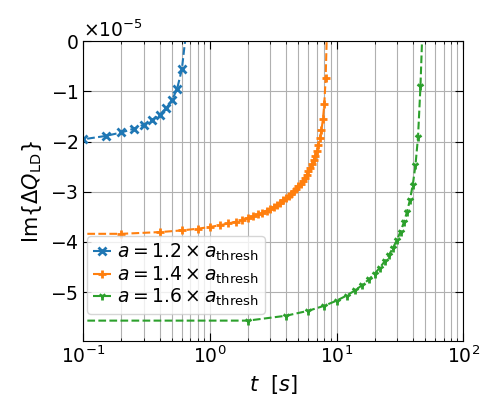

[-20.767 -20.167 -19.538 -18.879 -18.179 -17.432 -16.627 -15.711 -14.663
 -13.401 -11.798  -9.527  -5.616   2.08    0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.   ]
[-38.718 -38.384 -38.042 -37.704 -37.363 -37.02  -36.67  -36.323 -35.971
 -35.61  -35.251 -34.887 -34.515 -34.142 -33.761 -33.378 -32.982 -32.58
 -32.163 -31.741 -31.307 -30.86  -30.394 -29.918 -29.425 -28.914

In [43]:
# Print growthrate
figheightpres=5
plt.figure(figsize=(figwidth/1.2,figheightpres/1.2))
labels=r'$a=%.1f\times a_\mathrm{thresh}$'
for i,calc in enumerate(calcs):
    if i==3: continue
    plt.plot(calc.tsODE,calc.growthRatex[:calc.nt],'--%s'%markers[1+i],label=labels%(calc.M.Q.ax0/1e-4))
    print(calc.growthRatex*1e6)
    
plt.grid(True)
plt.ylim(top=0)
plt.ylabel(r"$\operatorname{Im}\{ \Delta Q_\mathrm{LD}\}$")
plt.xlabel(r'$t$  $[s]$')
plt.legend(loc=(0.01,0.09),labelspacing=0.07)
plt.xscale('log')
plt.xlim(0.1,100)
plt.grid(True,axis='x',which='minor')
plt.tight_layout()
plt.savefig(pltstorage+'NEW_becomeUnstable.eps')

# Misc

In [144]:
from pprint import pprint
X=vars(calc)
Y=dir(calc)
print(Y)
for y in Y:
    try:
        print(y,np.size(X[y]))
    except:
        None
['DiffE', 'DiffN', 'DiffS', 'DiffW', 'DriftE', 'DriftN', 'DriftS', 'DriftW', 'FV_M',
'psi0', 'psis', 'psis1Dx', 'psis1Dy', 'psis2D', 'psisPosX', 'psisPosY',
'dPsis1DdJx', 'dPsis1DdJy', 'dPsis2DdJx', 'dPsis2DdJy']

['BC_V', 'DiffE', 'DiffN', 'DiffS', 'DiffW', 'DriftE', 'DriftN', 'DriftS', 'DriftW', 'FV_M', 'G', 'J1D_proj_x1D', 'J2D_proj_J1D', 'M', 'ND', 'SD_calcEffectiveStrength', 'SD_calcEvolution', 'SD_calcScaledPsi0', 'SD_calcStabilityMargin', 'SD_copyScaledPsi0', 'SD_plotEffectiveStrength', 'SD_plotSD', 'SD_plotStabilityMargin', 'SD_plotWaterfall', '_IC', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slotnames__', '__str__', '__subclasshook__', '__weakref__', '_calc_BC_V_1D', '_workerSD', '_worker_psix', '_worker_psiy', 'bool_IC_point', 'calc_BC_V', 'calc_Coeff', 'calc_FV_M', 'calc_InterpDist', 'cart_x', 'cart_y', 'cohDQsAllx', 'cohDQsAlly', 'cohDQs_halfIx', 'cohDQs_halfIy', 'cohDQs_psi0_scaledx', 'cohDQs_psi0_scaledy', 'dPsis1DdJx', 'dPsis1DdJy', 'dPsis2DdJx', '

['DiffE',
 'DiffN',
 'DiffS',
 'DiffW',
 'DriftE',
 'DriftN',
 'DriftS',
 'DriftW',
 'FV_M',
 'psi0',
 'psis',
 'psis1Dx',
 'psis1Dy',
 'psis2D',
 'psisPosX',
 'psisPosY',
 'dPsis1DdJx',
 'dPsis1DdJy',
 'dPsis2DdJx',
 'dPsis2DdJy']